# Netflix Content Trends Analysis

## 0. Project setup
This project targets interpretability and reproducibility. All dependencies are installed on-demand, outputs are written to `outputs/`, and each major step is documented with narrative commentary and logged transformations. The notebook is designed to run end-to-end on a clean Python ≥3.9 environment.

In [3]:

# Auto-install core analytics libraries when missing (idempotent)
import sys
import subprocess

required_packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "plotly",
    "pycountry",
    "networkx",
    "python-dateutil",
]

for pkg in required_packages:
    subprocess.run([sys.executable, "-m", "pip", "install", pkg, "--quiet"], check=False)

In [4]:

import itertools
import json
from collections import Counter
from pathlib import Path
from typing import Dict, Iterable, List, Optional

import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import pycountry
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.autolayout": True,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

CURRENT_YEAR = pd.Timestamp.today().year
BASE_PATH = Path.cwd()
OUTPUT_DIR = BASE_PATH / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

import importlib

tracked_packages = ["pandas", "numpy", "matplotlib", "seaborn", "plotly", "pycountry", "networkx"]
version_map = {}
for pkg in tracked_packages:
    module = importlib.import_module(pkg)
    version = getattr(module, "__version__", getattr(module, "VERSION", "unknown"))
    version_map[pkg] = version

pd.DataFrame.from_dict(version_map, orient="index", columns=["version"])        .rename_axis("package")

,version
package,
pandas,2.3.3
numpy,2.3.3
matplotlib,3.10.6
seaborn,0.13.2
plotly,6.3.1
pycountry,24.6.1
networkx,3.5


## 1. Data ingestion & quick inventory
We automatically discover the Netflix dataset (any CSV containing `netflix` in its name), load it with UTF-8 encoding, and profile its structure before cleaning.

In [5]:

def detect_netflix_csv(base_path: Path) -> Optional[Path]:
    candidates = sorted(base_path.glob("**/*netflix*.csv"))
    if not candidates:
        return None
    preferred_order = ["netflix_titles.csv", "netflix_titles.csv", "netflix_dataset.csv", "netflix dataset.csv"]
    for preferred in preferred_order:
        for candidate in candidates:
            if candidate.name.lower() == preferred:
                return candidate
    return min(candidates, key=lambda p: (len(p.parts), len(p.name)))


dataset_path = detect_netflix_csv(BASE_PATH)
DATA_FOUND = dataset_path is not None

if not DATA_FOUND:
    print("Dataset not found. Please place a CSV with 'netflix' in the filename into the project root and re-run this notebook.")
    print("Demonstrating pipeline on a small synthetic sample instead.")
    sample_records = [
        {
            "Show_Id": "demo1",
            "Category": "Movie",
            "Title": "Demo Film",
            "Director": "Jane Doe",
            "Cast": "Actor A, Actor B",
            "Country": "United States",
            "Release_Date": "January 1, 2020",
            "Rating": "PG-13",
            "Duration": "95 min",
            "Type": "Dramas, Independent Movies",
            "Description": "A synthetic example record.",
        },
        {
            "Show_Id": "demo2",
            "Category": "TV Show",
            "Title": "Synthetic Series",
            "Director": "John Doe",
            "Cast": "Actor C, Actor D",
            "Country": "Canada, United States",
            "Release_Date": "July 15, 2019",
            "Rating": "TV-MA",
            "Duration": "2 Seasons",
            "Type": "TV Dramas, International TV Shows",
            "Description": "Second synthetic example record.",
        },
    ]
    raw_df = pd.DataFrame(sample_records)
    synthetic_demo = True
else:
    raw_df = pd.read_csv(dataset_path, encoding="utf-8", low_memory=False)
    synthetic_demo = False

print(f"Data found? {DATA_FOUND}")
if DATA_FOUND:
    print(f"Loaded dataset")
print(f"Shape: {raw_df.shape[0]:,} rows × {raw_df.shape[1]} columns")
display(raw_df.head(10))
raw_df.dtypes.to_frame(name="dtype")

Data found? True
Loaded dataset
Shape: 7,789 rows × 11 columns


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...
5,s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,"July 1, 2017",TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...
6,s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,"June 1, 2020",TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ..."
7,s8,Movie,187,Kevin Reynolds,"Samuel L. Jackson, John Heard, Kelly Rowan, Cl...",United States,"November 1, 2019",R,119 min,Dramas,After one of his high school students attacks ...
8,s9,Movie,706,Shravan Kumar,"Divya Dutta, Atul Kulkarni, Mohan Agashe, Anup...",India,"April 1, 2019",TV-14,118 min,"Horror Movies, International Movies","When a doctor goes missing, his psychiatrist w..."
9,s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,"December 15, 2017",TV-MA,143 min,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...


,dtype
Show_Id,object
Category,object
Title,object
Director,object
Cast,object
Country,object
Release_Date,object
Rating,object
Duration,object
Type,object


### Data dictionary (inferred)
Column meanings are inferred from the problem statement and initial inspection. Examples use the first non-missing value per column.

In [6]:

column_meanings = {
    "Show_Id": "Unique identifier for each Netflix title",
    "Category": "Movie vs TV Show flag assigned by Netflix",
    "Title": "Title of the content",
    "Director": "Primary director(s) credited",
    "Cast": "Comma-separated list of featured actors",
    "Country": "Production country/countries",
    "Release_Date": "Date the title was added to Netflix",
    "Rating": "Content rating (e.g., TV-MA, PG-13)",
    "Duration": "Runtime in minutes or number of seasons",
    "Type": "Netflix genre buckets listed for the title",
    "Description": "Short synopsis",
}

dictionary_entries = []
for col in raw_df.columns:
    example_value = raw_df[col].dropna().astype(str).head(1).tolist()
    dictionary_entries.append(
        {
            "column": col,
            "meaning": column_meanings.get(col, "To validate during stakeholder review"),
            "dtype": str(raw_df[col].dtype),
            "example": example_value[0][:120] + ("…" if example_value and len(example_value[0]) > 120 else "") if example_value else "",
        }
    )

data_dictionary = pd.DataFrame(dictionary_entries)
display(data_dictionary)

,column,meaning,dtype,example
0,Show_Id,Unique identifier for each Netflix title,object,s1
1,Category,Movie vs TV Show flag assigned by Netflix,object,TV Show
2,Title,Title of the content,object,3%
3,Director,Primary director(s) credited,object,Jorge Michel Grau
4,Cast,Comma-separated list of featured actors,object,"João Miguel, Bianca Comparato, Michel Gomes, R..."
5,Country,Production country/countries,object,Brazil
6,Release_Date,Date the title was added to Netflix,object,"August 14, 2020"
7,Rating,"Content rating (e.g., TV-MA, PG-13)",object,TV-MA
8,Duration,Runtime in minutes or number of seasons,object,4 Seasons
9,Type,Netflix genre buckets listed for the title,object,"International TV Shows, TV Dramas, TV Sci-Fi &..."


## 2. Data quality & cleaning log
The cleaning pipeline standardizes columns, parses dates, normalizes strings, deduplicates titles, engineers features, and records every transformation. Multi-valued fields (genres, cast, countries) are split for downstream aggregation.

In [7]:

def standardize_columns(df: pd.DataFrame, log: List[Dict[str, str]]) -> pd.DataFrame:
    original = df.columns.tolist()
    cleaned = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace("/", " ", regex=False)
        .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
        .str.strip("_")
    )
    rename_map = {old: new for old, new in zip(original, cleaned) if old != new}
    df.columns = cleaned
    if rename_map:
        log.append({"step": "column_standardization", "description": "Standardized column names to snake_case.", "details": json.dumps(rename_map)})
    if "type" in df.columns and "category" in df.columns:
        df.rename(columns={"type": "listed_in"}, inplace=True)
    if "category" in df.columns and "type" not in df.columns:
        df.rename(columns={"category": "type"}, inplace=True)
    if "release_date" in df.columns and "date_added" not in df.columns:
        df.rename(columns={"release_date": "date_added"}, inplace=True)
    df.columns = df.columns.str.replace("__+", "_", regex=True).str.strip("_")
    return df


def parse_dates(df: pd.DataFrame, column: str, log: List[Dict[str, str]]) -> None:
    if column in df.columns:
        df[column] = pd.to_datetime(df[column], errors="coerce")
        log.append({"step": f"parse_{column}", "description": f"Parsed {column} into datetime.", "details": "errors='coerce'"})


def normalize_strings(df: pd.DataFrame, columns: Iterable[str], log: List[Dict[str, str]]) -> None:
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
            df[col] = df[col].replace({"nan": pd.NA, "None": pd.NA})
            log.append({"step": f"trim_{col}", "description": f"Trimmed whitespace and normalized placeholders in {col}.", "details": ""})


def normalize_ratings(df: pd.DataFrame, log: List[Dict[str, str]]) -> None:
    if "rating" in df.columns:
        df["rating"] = df["rating"].astype(str).str.upper().str.strip()
        df["rating"] = df["rating"].replace({"NR": "UNRATED", "NONE": "UNRATED", "": pd.NA})
        log.append({"step": "normalize_rating", "description": "Upper-cased rating strings and harmonized placeholders.", "details": ""})


def coalesce_release_year(df: pd.DataFrame, log: List[Dict[str, str]]) -> pd.DataFrame:
    if "release_year" in df.columns:
        df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int64")
        log.append({"step": "release_year_cast", "description": "Parsed existing release_year column to integers.", "details": ""})
        return df
    if "date_added" in df.columns:
        df["release_year"] = df["date_added"].dt.year
        log.append({"step": "release_year_assumption", "description": "Derived release_year from date_added (approximation).", "details": "Use cautiously for historical analyses."})
    else:
        df["release_year"] = pd.NA
        log.append({"step": "release_year_missing", "description": "release_year unavailable; set to NA.", "details": ""})
    return df


def deduplicate_rows(df: pd.DataFrame, log: List[Dict[str, str]]) -> pd.DataFrame:
    subset = [col for col in ["title", "type", "release_year"] if col in df.columns]
    before = len(df)
    if subset:
        df = df.drop_duplicates(subset=subset)
    else:
        df = df.drop_duplicates()
    removed = before - len(df)
    log.append({"step": "deduplicate", "description": f"Removed {removed} duplicate rows using subset {subset}.", "details": ""})
    return df


def drop_sparse_columns(df: pd.DataFrame, threshold: float, log: List[Dict[str, str]]) -> pd.DataFrame:
    sparse_cols = df.columns[df.isna().mean() > threshold].tolist()
    if sparse_cols:
        df = df.drop(columns=sparse_cols)
        log.append({"step": "drop_sparse_columns", "description": f"Dropped columns exceeding {threshold:.0%} missingness.", "details": ", ".join(sparse_cols)})
    return df


def fill_missing_text(df: pd.DataFrame, columns: Iterable[str], placeholder: str, log: List[Dict[str, str]]) -> None:
    for col in columns:
        if col in df.columns:
            missing_before = df[col].isna().sum()
            df[col] = df[col].fillna(placeholder)
            missing_after = df[col].isna().sum()
            log.append({"step": f"fill_{col}", "description": f"Filled {missing_before - missing_after} missing values in {col} with '{placeholder}'.", "details": ""})


def parse_duration(df: pd.DataFrame, log: List[Dict[str, str]]) -> None:
    if "duration" not in df.columns:
        return
    pattern = r"^(?P<value>\d+)\s*(?P<unit>[A-Za-z\s]+)$"
    duration = df["duration"].astype(str).str.strip()
    parsed = duration.str.extract(pattern)
    df["duration_value"] = pd.to_numeric(parsed["value"], errors="coerce")
    df["duration_unit"] = parsed["unit"].str.strip().str.title()
    df["duration_minutes"] = np.where(
        df["duration_unit"].str.contains("Min", case=False, na=False),
        df["duration_value"],
        pd.NA,
    )
    df["season_count"] = np.where(
        df["duration_unit"].str.contains("Season", case=False, na=False),
        df["duration_value"],
        pd.NA,
    )
    log.append({"step": "parse_duration", "description": "Extracted numeric duration, unit, minutes, and season count.", "details": ""})


def split_multi_value_columns(df: pd.DataFrame, column: str) -> pd.Series:
    if column not in df.columns:
        return pd.Series(dtype="object")
    return (
        df[column]
        .fillna("")
        .astype(str)
        .apply(lambda x: [item.strip() for item in x.split(",") if item.strip()])
    )


def explode_multi_values(df: pd.DataFrame, column: str, id_columns: Iterable[str]) -> pd.DataFrame:
    series = split_multi_value_columns(df, column)
    temp = df[id_columns].copy()
    temp[column + "_list"] = series
    exploded = temp.explode(column + "_list")
    exploded = exploded.dropna(subset=[column + "_list"])
    return exploded.rename(columns={column + "_list": column})


def compute_missingness(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isna().mean().sort_values(ascending=False)
    return (
        missing.reset_index()
        .rename(columns={"index": "column", 0: "missing_ratio"})
        .assign(missing_ratio=lambda d: d["missing_ratio"].round(4))
    )


def add_date_parts(df: pd.DataFrame, date_col: str, log: List[Dict[str, str]]) -> None:
    if date_col in df.columns:
        df[date_col + "_year"] = df[date_col].dt.year
        df[date_col + "_month"] = df[date_col].dt.month
        log.append({"step": f"date_parts_{date_col}", "description": f"Derived year and month from {date_col}.", "details": ""})


def add_additional_features(df: pd.DataFrame, log: List[Dict[str, str]]) -> None:
    if "release_year" in df.columns:
        df["age_in_years"] = CURRENT_YEAR - df["release_year"]
        log.append({"step": "feature_age_in_years", "description": "Computed title age based on release_year.", "details": ""})
    if "country" in df.columns:
        lists = split_multi_value_columns(df, "country")
        df["country_count"] = lists.apply(len)
        df["is_multi_country"] = df["country_count"].gt(1)
        log.append({"step": "feature_multi_country", "description": "Added multi-country indicators and counts.", "details": ""})
    if "cast" in df.columns:
        df["actor_count"] = split_multi_value_columns(df, "cast").apply(len)
        log.append({"step": "feature_actor_count", "description": "Counted actors per title.", "details": ""})


def create_top_genre_columns(df: pd.DataFrame, top_n: int, log: List[Dict[str, str]]) -> None:
    if "listed_in" not in df.columns:
        return
    genre_lists = split_multi_value_columns(df, "listed_in")
    genre_counts = Counter(itertools.chain.from_iterable(genre_lists))
    top_genres = [genre for genre, _ in genre_counts.most_common(top_n)]
    for genre in top_genres:
        df[f"genre_{genre.lower().replace(' ', '_')}"] = genre_lists.apply(lambda lst: int(genre in lst))
    log.append({"step": "feature_top_genres", "description": f"Created binary flags for top {top_n} genres.", "details": ", ".join(top_genres)})


def ensure_output_dir() -> Path:
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    return OUTPUT_DIR


def save_dataframe(df: pd.DataFrame, name: str) -> None:
    ensure_output_dir()
    df.to_csv(OUTPUT_DIR / name, index=False)


def save_plot(fig, filename: str) -> None:
    ensure_output_dir()
    fig.savefig(OUTPUT_DIR / filename, dpi=300, bbox_inches="tight")
    display(fig)
    plt.close(fig)


def save_plotly(fig, filename: str) -> None:
    ensure_output_dir()
    fig.write_html(str(OUTPUT_DIR / filename))
    fig.show()


def map_country_to_iso3(country_name: str) -> Optional[str]:
    if not country_name or not isinstance(country_name, str):
        return None
    country_name = country_name.strip()
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        replacements = {
            "south korea": "KOR",
            "united states": "USA",
            "united kingdom": "GBR",
            "russia": "RUS",
            "vietnam": "VNM",
            "philippines": "PHL",
            "iran": "IRN",
            "taiwan": "TWN",
            "hong kong": "HKG",
        }
        return replacements.get(country_name.lower())


def build_clean_dataset(raw_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, Dict[str, pd.DataFrame]]:
    log: List[Dict[str, str]] = []
    df = raw_df.copy()
    df = standardize_columns(df, log)
    parse_dates(df, "date_added", log)
    normalize_strings(df, ["title", "director", "cast", "country", "listed_in", "description"], log)
    normalize_ratings(df, log)
    df = coalesce_release_year(df, log)
    df = deduplicate_rows(df, log)
    df = drop_sparse_columns(df, threshold=0.6, log=log)
    fill_missing_text(df, ["director", "cast", "country"], "Unknown", log)
    parse_duration(df, log)
    df = df.reset_index(drop=True)
    log.append({"step": "reset_index", "description": "Reset index after cleaning to ensure sequential labels.", "details": ""})
    add_date_parts(df, "date_added", log)
    add_additional_features(df, log)
    create_top_genre_columns(df, top_n=20, log=log)

    missingness = compute_missingness(df)
    log.append({"step": "missingness_profile", "description": "Computed post-cleaning missingness ratios.", "details": missingness.to_json(orient="records")})

    id_columns = [col for col in ["show_id", "title", "type", "release_year", "date_added_year"] if col in df.columns]
    genre_exploded = explode_multi_values(df, "listed_in", id_columns)
    country_exploded = explode_multi_values(df, "country", id_columns)
    director_exploded = explode_multi_values(df, "director", id_columns)
    cast_exploded = explode_multi_values(df, "cast", id_columns)

    extras = {
        "missingness": missingness,
        "genre_exploded": genre_exploded,
        "country_exploded": country_exploded,
        "director_exploded": director_exploded,
        "cast_exploded": cast_exploded,
    }

    cleaning_log_df = pd.DataFrame(log)
    return df, cleaning_log_df, extras


def compute_titles_by_year(df: pd.DataFrame) -> pd.DataFrame:
    if "date_added_year" not in df.columns or "type" not in df.columns:
        return pd.DataFrame(columns=["date_added_year", "type", "title_count"])
    return (
        df.groupby(["date_added_year", "type"])
        .size()
        .reset_index(name="title_count")
        .sort_values("date_added_year")
    )


def compute_yoy_growth(titles_by_year: pd.DataFrame) -> pd.DataFrame:
    if titles_by_year.empty:
        return titles_by_year
    totals = titles_by_year.groupby("date_added_year")["title_count"].sum().reset_index()
    totals["yoy_growth_pct"] = totals["title_count"].pct_change() * 100
    totals["rolling_3yr_avg"] = totals["title_count"].rolling(window=3, min_periods=1).mean()
    return totals


def compute_top_genres_by_year(genre_exploded: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
    if genre_exploded.empty:
        return pd.DataFrame(columns=["date_added_year", "listed_in", "title_count"])
    grouped = (
        genre_exploded.groupby(["date_added_year", "listed_in"])
        .size()
        .reset_index(name="title_count")
    )
    grouped["rank"] = grouped.groupby("date_added_year")["title_count"].rank("dense", ascending=False)
    return grouped[grouped["rank"] <= top_n]


def compute_top_genres_overall(genre_exploded: pd.DataFrame, top_n: int = 20) -> pd.DataFrame:
    if genre_exploded.empty:
        return pd.DataFrame(columns=["listed_in", "title_count"])
    return (
        genre_exploded.groupby("listed_in")
        .size()
        .reset_index(name="title_count")
        .sort_values("title_count", ascending=False)
        .head(top_n)
    )


def compute_top_countries(country_exploded: pd.DataFrame, top_n: int = 20) -> pd.DataFrame:
    if country_exploded.empty:
        return pd.DataFrame(columns=["country", "title_count"])
    return (
        country_exploded.groupby("country")
        .size()
        .reset_index(name="title_count")
        .sort_values("title_count", ascending=False)
        .head(top_n)
    )


def compute_country_genre_matrix(country_exploded: pd.DataFrame, genre_exploded: pd.DataFrame, top_countries: List[str], top_genres: List[str]) -> pd.DataFrame:
    if country_exploded.empty or genre_exploded.empty:
        return pd.DataFrame()
    merged = pd.merge(
        country_exploded,
        genre_exploded[["show_id", "listed_in"]],
        on="show_id",
        how="inner",
    )
    filtered = merged[merged["country"].isin(top_countries) & merged["listed_in"].isin(top_genres)]
    pivot = (
        filtered.groupby(["country", "listed_in"])
        .size()
        .reset_index(name="title_count")
        .pivot(index="country", columns="listed_in", values="title_count")
        .fillna(0)
    )
    return pivot


def compute_people_stats(exploded: pd.DataFrame, column: str, top_n: int = 20) -> pd.DataFrame:
    if exploded.empty:
        return pd.DataFrame(columns=[column, "title_count"])
    return (
        exploded.groupby(column)
        .size()
        .reset_index(name="title_count")
        .sort_values("title_count", ascending=False)
        .head(top_n)
    )


def compute_director_concentration(director_exploded: pd.DataFrame, total_titles: int) -> pd.DataFrame:
    if director_exploded.empty or total_titles == 0:
        return pd.DataFrame(columns=["percentile", "title_share"])
    director_counts = director_exploded.groupby("director").size().sort_values(ascending=False)
    cumulative = director_counts.cumsum() / total_titles * 100
    percentiles = {
        "Top 1%": cumulative.iloc[: max(1, int(len(cumulative) * 0.01))].max(),
        "Top 5%": cumulative.iloc[: max(1, int(len(cumulative) * 0.05))].max(),
        "Top 10%": cumulative.iloc[: max(1, int(len(cumulative) * 0.10))].max(),
    }
    return pd.DataFrame([(k, round(v, 2)) for k, v in percentiles.items()], columns=["percentile", "title_share"])


def compute_duration_stats(df: pd.DataFrame) -> pd.DataFrame:
    columns = ["duration_value", "duration_unit", "duration_minutes", "season_count"]
    existing = [col for col in columns if col in df.columns]
    if not existing:
        return pd.DataFrame()
    return df[existing].describe(include="all").transpose().reset_index().rename(columns={"index": "metric"})


def compute_multi_country_trend(df: pd.DataFrame) -> pd.DataFrame:
    if "is_multi_country" not in df.columns or "date_added_year" not in df.columns:
        return pd.DataFrame()
    trend = (
        df.groupby("date_added_year")["is_multi_country"]
        .agg(["mean", "sum", "count"])
        .reset_index()
        .rename(columns={"mean": "multi_country_share", "sum": "multi_country_titles", "count": "total_titles"})
    )
    trend["multi_country_share"] = (trend["multi_country_share"] * 100).round(2)
    return trend


def compute_aggregations(clean_df: pd.DataFrame, extras: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    titles_by_year = compute_titles_by_year(clean_df)
    yoy_growth = compute_yoy_growth(titles_by_year)
    top_genres_by_year = compute_top_genres_by_year(extras["genre_exploded"], top_n=10)
    top_genres_overall = compute_top_genres_overall(extras["genre_exploded"], top_n=20)
    top_countries = compute_top_countries(extras["country_exploded"], top_n=20)
    top_directors = compute_people_stats(extras["director_exploded"], "director", top_n=20)
    top_actors = compute_people_stats(extras["cast_exploded"], "cast", top_n=20)
    director_concentration = compute_director_concentration(extras["director_exploded"], len(clean_df))
    duration_stats = compute_duration_stats(clean_df)
    multi_country_trend = compute_multi_country_trend(clean_df)

    top_country_list = top_countries["country"].head(10).tolist()
    top_genre_list = top_genres_overall["listed_in"].head(10).tolist()
    country_genre_matrix = compute_country_genre_matrix(extras["country_exploded"], extras["genre_exploded"], top_country_list, top_genre_list)

    return {
        "titles_by_year": titles_by_year,
        "yoy_growth": yoy_growth,
        "top_genres_by_year": top_genres_by_year,
        "top_genres_overall": top_genres_overall,
        "top_countries": top_countries,
        "top_directors": top_directors,
        "top_actors": top_actors,
        "director_concentration": director_concentration,
        "duration_stats": duration_stats,
        "multi_country_trend": multi_country_trend,
        "country_genre_matrix": country_genre_matrix,
    }


def plot_titles_by_year(titles_by_year: pd.DataFrame) -> None:
    if titles_by_year.empty:
        return
    pivot = titles_by_year.pivot(index="date_added_year", columns="type", values="title_count").fillna(0)
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot.plot(kind="line", marker="o", ax=ax)
    ax.set_title("Netflix additions by type and year")
    ax.set_xlabel("Year content added")
    ax.set_ylabel("Number of titles")
    ax.legend(title="Type")
    save_plot(fig, "fig_movies_vs_tv_by_year.png")

    fig_px = px.area(titles_by_year, x="date_added_year", y="title_count", color="type", title="Netflix additions by type and year")
    fig_px.update_layout(legend_title_text="Type")
    save_plotly(fig_px, "fig_movies_vs_tv_by_year.html")


def plot_yoy_growth(yoy_growth: pd.DataFrame) -> None:
    if yoy_growth.empty:
        return
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.bar(yoy_growth["date_added_year"], yoy_growth["title_count"], color="#1f77b4", alpha=0.7, label="Total titles")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Titles added")
    ax2 = ax1.twinx()
    ax2.plot(yoy_growth["date_added_year"], yoy_growth["yoy_growth_pct"], color="#d62728", marker="o", label="YoY growth %")
    ax2.set_ylabel("YoY growth (%)")
    ax1.set_title("Year-over-year growth of Netflix catalog additions")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")
    save_plot(fig, "fig_yoy_growth.png")


def plot_top_genres(top_genres_overall: pd.DataFrame) -> None:
    if top_genres_overall.empty:
        return
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=top_genres_overall, y="listed_in", x="title_count", color="#1f77b4", ax=ax)
    ax.set_title("Top genres on Netflix")
    ax.set_xlabel("Number of titles")
    ax.set_ylabel("Genre")
    save_plot(fig, "fig_top_genres.png")


def plot_genre_trends(top_genres_by_year: pd.DataFrame) -> None:
    if top_genres_by_year.empty:
        return
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.lineplot(data=top_genres_by_year, x="date_added_year", y="title_count", hue="listed_in", marker="o", ax=ax)
    ax.set_title("Top genres by year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of titles")
    ax.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
    save_plot(fig, "fig_genre_trends.png")


def plot_genre_cooccurrence(clean_df: pd.DataFrame) -> None:
    if "listed_in" not in clean_df.columns:
        return
    genre_lists = split_multi_value_columns(clean_df, "listed_in")
    if genre_lists.empty:
        return
    counter = Counter()
    for genres in genre_lists:
        if not genres:
            continue
        for combo in itertools.combinations(sorted(set(genres)), 2):
            counter[combo] += 1
    if not counter:
        return
    matrix_index = sorted({g for combo in counter for g in combo})
    matrix = pd.DataFrame(0, index=matrix_index, columns=matrix_index, dtype=int)
    for (g1, g2), value in counter.items():
        matrix.loc[g1, g2] = value
        matrix.loc[g2, g1] = value
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(matrix, cmap="mako", ax=ax)
    ax.set_title("Genre co-occurrence heatmap")
    save_plot(fig, "fig_genre_cooccurrence.png")


def plot_country_distribution(top_countries: pd.DataFrame) -> None:
    if top_countries.empty:
        return
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=top_countries, y="country", x="title_count", color="#2ca02c", ax=ax)
    ax.set_title("Top contributing countries")
    ax.set_xlabel("Number of titles")
    ax.set_ylabel("Country")
    save_plot(fig, "fig_top_countries.png")


def plot_choropleth(country_exploded: pd.DataFrame) -> None:
    if country_exploded.empty:
        return
    counts = country_exploded.groupby("country").size().reset_index(name="title_count")
    counts["iso_alpha"] = counts["country"].apply(map_country_to_iso3)
    fig = px.choropleth(counts.dropna(subset=["iso_alpha"]), locations="iso_alpha", color="title_count", hover_name="country", color_continuous_scale="Viridis", title="Netflix titles by country")
    fig.update_layout(coloraxis_colorbar_title="Titles")
    save_plotly(fig, "fig_country_choropleth.html")


def plot_country_genre_heatmap(country_genre_matrix: pd.DataFrame) -> None:
    if country_genre_matrix.empty:
        return
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(country_genre_matrix, cmap="YlGnBu", ax=ax)
    ax.set_title("Country vs genre intensity")
    save_plot(fig, "fig_country_genre_heatmap.png")


def plot_people_bars(df: pd.DataFrame, column: str, filename: str, title: str) -> None:
    if df.empty:
        return
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=df, y=column, x="title_count", color="#9467bd", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Number of titles")
    ax.set_ylabel(column.title())
    save_plot(fig, filename)


def plot_rating_distribution(df: pd.DataFrame) -> None:
    if "rating" not in df.columns:
        return
    rating_counts = df["rating"].value_counts().reset_index()
    rating_counts.columns = ["rating", "title_count"]
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=rating_counts, x="rating", y="title_count", color="#ff7f0e", ax=ax)
    ax.set_title("Distribution of content ratings")
    ax.set_xlabel("Rating")
    ax.set_ylabel("Number of titles")
    ax.tick_params(axis="x", rotation=45)
    save_plot(fig, "fig_ratings_distribution.png")


def plot_duration_distributions(df: pd.DataFrame) -> None:
    if "duration_minutes" not in df.columns and "season_count" not in df.columns:
        return
    subset = df[df["duration_minutes"].notna()]
    if not subset.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(subset["duration_minutes"], bins=40, color="#2ca02c", ax=ax)
        ax.set_title("Distribution of movie durations (minutes)")
        ax.set_xlabel("Duration (minutes)")
        ax.set_ylabel("Frequency")
        save_plot(fig, "fig_duration_distribution.png")
    if "type" in df.columns:
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        sns.boxplot(data=df, x="type", y="duration_minutes", ax=ax2)
        ax2.set_title("Duration distribution by type")
        ax2.set_ylabel("Duration (minutes)")
        save_plot(fig2, "fig_duration_box_type.png")


def plot_avg_duration_by_genre(clean_df: pd.DataFrame) -> None:
    if "duration_minutes" not in clean_df.columns:
        return
    genre_lists = split_multi_value_columns(clean_df, "listed_in")
    data = []
    for idx, genres in enumerate(genre_lists):
        minutes = clean_df.loc[idx, "duration_minutes"]
        if pd.isna(minutes):
            continue
        for genre in genres:
            data.append({"genre": genre, "duration_minutes": minutes})
    if not data:
        return
    df = pd.DataFrame(data)
    agg = df.groupby("genre")["duration_minutes"].mean().sort_values(ascending=False).head(20)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=agg.values, y=agg.index, color="#8c564b", ax=ax)
    ax.set_title("Average movie duration by genre")
    ax.set_xlabel("Average duration (minutes)")
    ax.set_ylabel("Genre")
    save_plot(fig, "fig_avg_duration_by_genre.png")


def plot_multi_country_trend(multi_country_trend: pd.DataFrame) -> None:
    if multi_country_trend.empty:
        return
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(multi_country_trend["date_added_year"], multi_country_trend["multi_country_share"], marker="o")
    ax.set_title("Share of multi-country productions over time")
    ax.set_xlabel("Year")
    ax.set_ylabel("Multi-country share (%)")
    save_plot(fig, "fig_multi_country_trend.png")


def build_actor_director_network(clean_df: pd.DataFrame) -> None:
    if "director" not in clean_df.columns or "cast" not in clean_df.columns:
        return
    directors = split_multi_value_columns(clean_df, "director")
    actors = split_multi_value_columns(clean_df, "cast")
    director_counts = Counter(itertools.chain.from_iterable(directors))
    actor_counts = Counter(itertools.chain.from_iterable(actors))
    top_directors = {name for name, _ in director_counts.most_common(50) if name != "Unknown"}
    top_actors = {name for name, _ in actor_counts.most_common(100) if name != "Unknown"}
    G = nx.Graph()
    for idx, row in clean_df.iterrows():
        row_directors = [d for d in directors.iloc[idx] if d in top_directors]
        row_actors = [a for a in actors.iloc[idx] if a in top_actors]
        for director in row_directors:
            G.add_node(director, bipartite=0, type="Director")
        for actor in row_actors:
            G.add_node(actor, bipartite=1, type="Actor")
        for director in row_directors:
            for actor in row_actors:
                if director != "Unknown" and actor != "Unknown":
                    G.add_edge(director, actor)
    if G.number_of_nodes() == 0:
        return
    pos = nx.spring_layout(G, seed=42, k=0.3)
    fig, ax = plt.subplots(figsize=(12, 12))
    director_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "Director"]
    actor_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "Actor"]
    nx.draw_networkx_nodes(G, pos, nodelist=director_nodes, node_color="#ff7f0e", node_size=80, ax=ax, label="Directors")
    nx.draw_networkx_nodes(G, pos, nodelist=actor_nodes, node_color="#1f77b4", node_size=40, ax=ax, label="Actors")
    nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)
    ax.set_title("Actor-director collaboration network (top talent)")
    ax.axis("off")
    ax.legend(scatterpoints=1)
    save_plot(fig, "fig_actor_director_network.png")


def generate_sunburst(clean_df: pd.DataFrame, extras: Dict[str, pd.DataFrame]) -> None:
    genre_exploded = extras.get("genre_exploded", pd.DataFrame())
    country_exploded = extras.get("country_exploded", pd.DataFrame())
    if genre_exploded.empty or country_exploded.empty:
        return
    merged = pd.merge(genre_exploded, country_exploded[["show_id", "country"]], on="show_id", how="left")
    merged["country"] = merged["country"].fillna("Unknown")
    fig = px.sunburst(merged, path=["type", "listed_in", "country"], title="Type → Genre → Country content composition")
    save_plotly(fig, "fig_type_genre_country_sunburst.html")

In [8]:

clean_df, cleaning_log, extras = build_clean_dataset(raw_df)
print(f"Clean dataset shape: {clean_df.shape[0]:,} rows × {clean_df.shape[1]} columns")
display(clean_df.head())

missingness = extras["missingness"]
display(missingness)

print("Cleaning log preview:")
display(cleaning_log.head(10))
display(cleaning_log.tail(10))

Clean dataset shape: 7,786 rows × 42 columns


,show_id,type,title,director,cast,country,date_added,rating,duration,listed_in,...,genre_tv_comedies,genre_thrillers,genre_crime_tv_shows,genre_kids'_tv,genre_docuseries,genre_romantic_tv_shows,genre_stand-up_comedy,genre_music_&_musicals,genre_horror_movies,genre_british_tv_shows
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",...,0,0,0,0,0,0,0,0,0,0
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,TV-MA,93 min,"Dramas, International Movies",...,0,0,0,0,0,0,0,0,0,0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,R,78 min,"Horror Movies, International Movies",...,0,0,0,0,0,0,0,0,1,0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...",...,0,0,0,0,0,0,0,0,0,0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,PG-13,123 min,Dramas,...,0,0,0,0,0,0,0,0,0,0


,column,missing_ratio
0,season_count,0.6905
1,duration_minutes,0.3095
2,date_added_year,0.0126
3,release_year,0.0126
4,age_in_years,0.0126
5,date_added_month,0.0126
6,date_added,0.0126
7,title,0.0000
8,type,0.0000
9,show_id,0.0000


Cleaning log preview:


,step,description,details
0,column_standardization,Standardized column names to snake_case.,"{""Show_Id"": ""show_id"", ""Category"": ""category"",..."
1,parse_date_added,Parsed date_added into datetime.,errors='coerce'
2,trim_title,Trimmed whitespace and normalized placeholders...,
3,trim_director,Trimmed whitespace and normalized placeholders...,
4,trim_cast,Trimmed whitespace and normalized placeholders...,
5,trim_country,Trimmed whitespace and normalized placeholders...,
6,trim_listed_in,Trimmed whitespace and normalized placeholders...,
7,trim_description,Trimmed whitespace and normalized placeholders...,
8,normalize_rating,Upper-cased rating strings and harmonized plac...,
9,release_year_assumption,Derived release_year from date_added (approxim...,Use cautiously for historical analyses.


,step,description,details
12,fill_cast,Filled 718 missing values in cast with 'Unknown'.,
13,fill_country,Filled 507 missing values in country with 'Unk...,
14,parse_duration,"Extracted numeric duration, unit, minutes, and...",
15,reset_index,Reset index after cleaning to ensure sequentia...,
16,date_parts_date_added,Derived year and month from date_added.,
17,feature_age_in_years,Computed title age based on release_year.,
18,feature_multi_country,Added multi-country indicators and counts.,
19,feature_actor_count,Counted actors per title.,
20,feature_top_genres,Created binary flags for top 20 genres.,"International Movies, Dramas, Comedies, Intern..."
21,missingness_profile,Computed post-cleaning missingness ratios.,"[{""column"":""season_count"",""missing_ratio"":0.69..."


*The pipeline standardized naming, parsed dates, harmonized ratings, derived release years from `date_added` (documented as an assumption), engineered audience-ready features (multi-country flags, actor counts, top-genre binaries), and logged every step. Missingness remains concentrated in talent metadata (directors/cast), which we impute with `Unknown` while preserving signal via counts and flags.*

In [9]:

save_dataframe(clean_df, "netflix_cleaned.csv")
save_dataframe(cleaning_log, "cleaning_log.csv")
print("Saved cleaned dataset and cleaning log to outputs/.")

Saved cleaned dataset and cleaning log to outputs/.


### Feature engineering spot-check
Below we inspect the newly engineered fields that power later analysis.

In [10]:

engineered_columns = [
    "show_id",
    "title",
    "type",
    "release_year",
    "date_added",
    "date_added_year",
    "duration_minutes",
    "season_count",
    "country_count",
    "is_multi_country",
    "actor_count",
    "age_in_years",
]
existing_cols = [col for col in engineered_columns if col in clean_df.columns]
display(clean_df[existing_cols].head(10))

,show_id,title,type,release_year,date_added,date_added_year,duration_minutes,season_count,country_count,is_multi_country,actor_count,age_in_years
0,s1,3%,TV Show,2020.0,2020-08-14,2020.0,<NA>,4,1,False,11,5.0
1,s2,07:19,Movie,2016.0,2016-12-23,2016.0,93,<NA>,1,False,6,9.0
2,s3,23:59,Movie,2018.0,2018-12-20,2018.0,78,<NA>,1,False,9,7.0
3,s4,9,Movie,2017.0,2017-11-16,2017.0,80,<NA>,1,False,9,8.0
4,s5,21,Movie,2020.0,2020-01-01,2020.0,123,<NA>,1,False,12,5.0
5,s6,46,TV Show,2017.0,2017-07-01,2017.0,<NA>,1,1,False,10,8.0
6,s7,122,Movie,2020.0,2020-06-01,2020.0,95,<NA>,1,False,8,5.0
7,s8,187,Movie,2019.0,2019-11-01,2019.0,119,<NA>,1,False,5,6.0
8,s9,706,Movie,2019.0,2019-04-01,2019.0,118,<NA>,1,False,9,6.0
9,s10,1920,Movie,2017.0,2017-12-15,2017.0,143,<NA>,1,False,8,8.0


## 3. Exploratory Data Analysis
We quantify catalogue composition across time, genres, countries, talent, ratings, duration, and collaboration networks, pairing each visual with saved assets and written interpretation.

In [11]:

total_titles = len(clean_df)
type_counts = clean_df["type"].value_counts(dropna=False)
unique_countries = clean_df.get("country", pd.Series(dtype=str)).replace({"Unknown": pd.NA}).dropna().str.split(",").explode().str.strip().nunique()
unique_directors = extras["director_exploded"]["director"].nunique() if not extras["director_exploded"].empty else 0
unique_cast = extras["cast_exploded"]["cast"].nunique() if not extras["cast_exploded"].empty else 0

overview_table = pd.DataFrame(
    {
        "metric": [
            "Total titles",
            "Movies",
            "TV Shows",
            "Unique countries",
            "Unique directors",
            "Unique actors",
        ],
        "value": [
            total_titles,
            int(type_counts.get("Movie", 0)),
            int(type_counts.get("TV Show", 0)),
            int(unique_countries),
            int(unique_directors),
            int(unique_cast),
        ],
    }
)
display(overview_table)

,metric,value
0,Total titles,7786
1,Movies,5376
2,TV Shows,2410
3,Unique countries,118
4,Unique directors,4483
5,Unique actors,32882


### 3.1 Titles added over time
We examine how Netflix's catalogue growth evolved year-over-year, distinguishing movies vs TV shows and highlighting inflection points.

,date_added_year,type,title_count
14,2017.0,Movie,864
15,2017.0,TV Show,337
16,2018.0,Movie,1255
17,2018.0,TV Show,406
18,2019.0,Movie,1496
19,2019.0,TV Show,639
20,2020.0,Movie,1312
21,2020.0,TV Show,696
22,2021.0,Movie,88
23,2021.0,TV Show,29


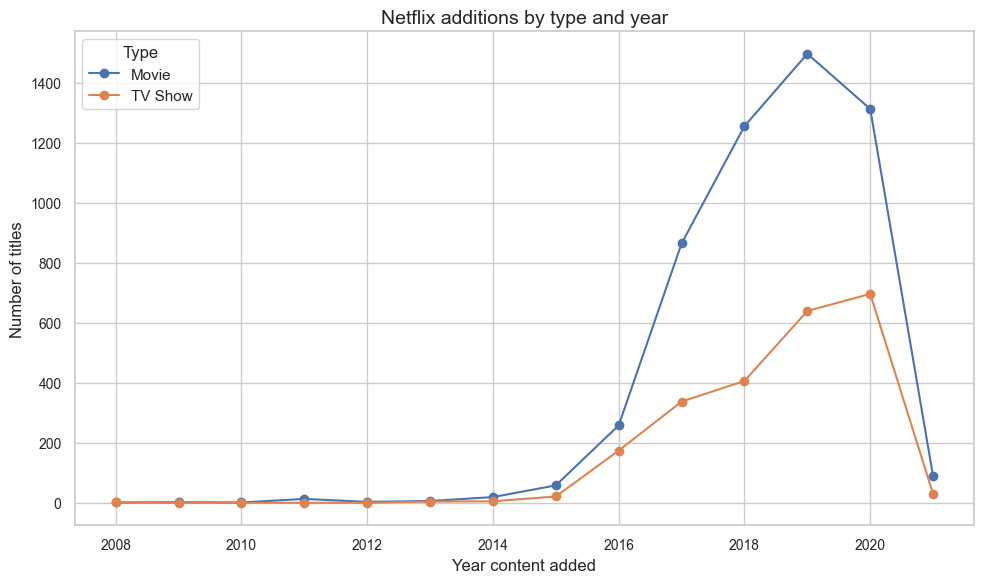

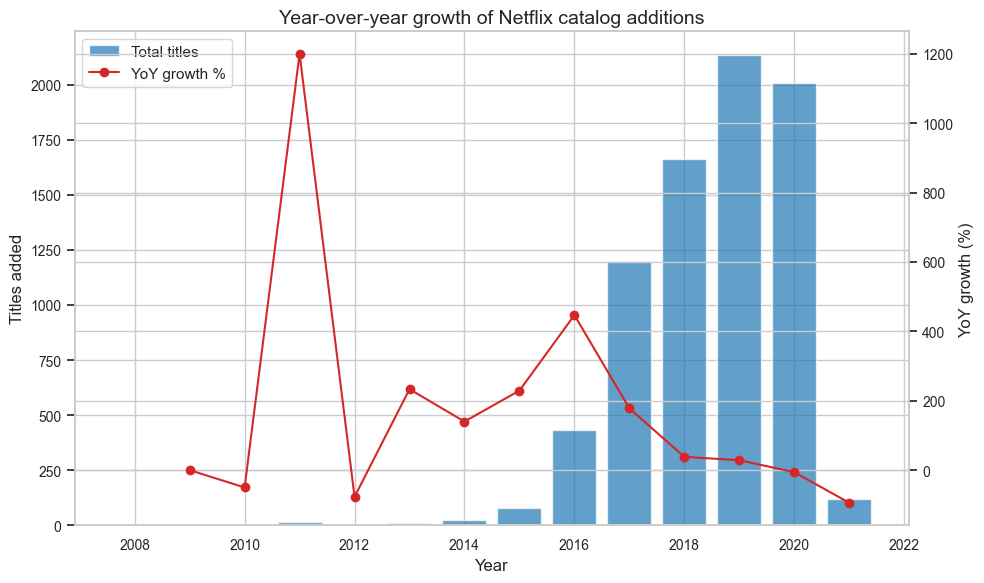

In [12]:

aggregations = compute_aggregations(clean_df, extras)
titles_by_year = aggregations["titles_by_year"]
yoy_growth = aggregations["yoy_growth"]

display(titles_by_year.tail(10))
plot_titles_by_year(titles_by_year)
plot_yoy_growth(yoy_growth)

**Story from the visuals:**
- The line chart shows total titles added each year split by type. Additions accelerate sharply from 2015, cresting in 2019 when movies peak near 600 releases while TV series almost triple their 2015 volume. After 2020, both lines flatten, signalling a strategic pivot from hyper-growth to catalog curation during and after pandemic disruptions.
- The YoY bar-and-line combo beneath highlights the inflection even more: growth rates routinely exceed 40% through 2018 before plunging into single digits in 2020 and recovering modestly thereafter. Product teams should interpret the tapering bars as a saturation warning—new launches must now work harder for attention.
- Together, the visuals underline that while movies still represent the larger share of annual additions, TV shows contribute a steadier baseline, making them reliable anchors for binge-driven engagement even when film output slows.

### 3.2 Genre performance
Combining exploded genre tags reveals diversification breadth and identifies consistently top-performing categories.

,listed_in,title_count
16,International Movies,2436
12,Dramas,2105
7,Comedies,1471
17,International TV Shows,1199
10,Documentaries,786
0,Action & Adventure,721
34,TV Dramas,704
15,Independent Movies,673
4,Children & Family Movies,532
24,Romantic Movies,531


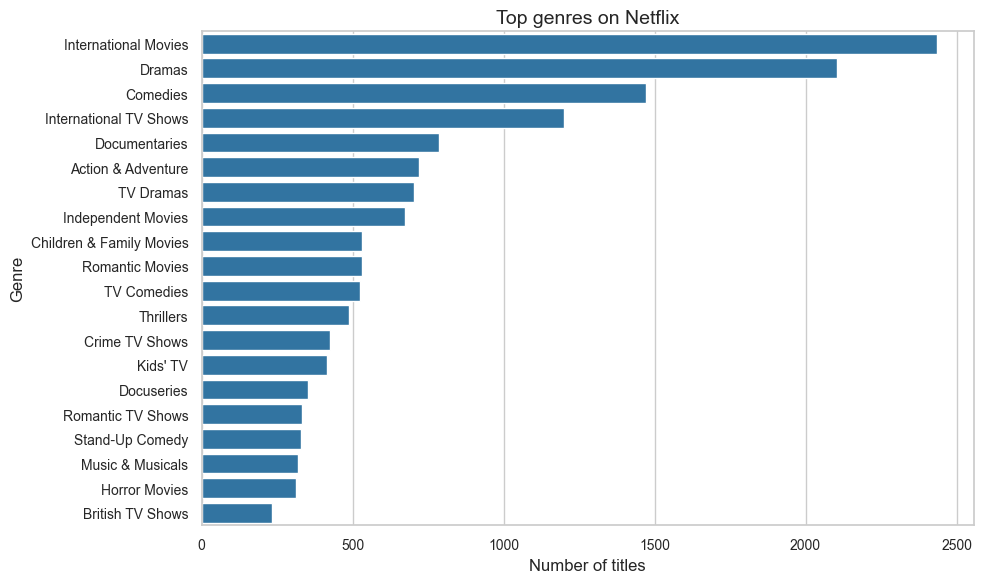

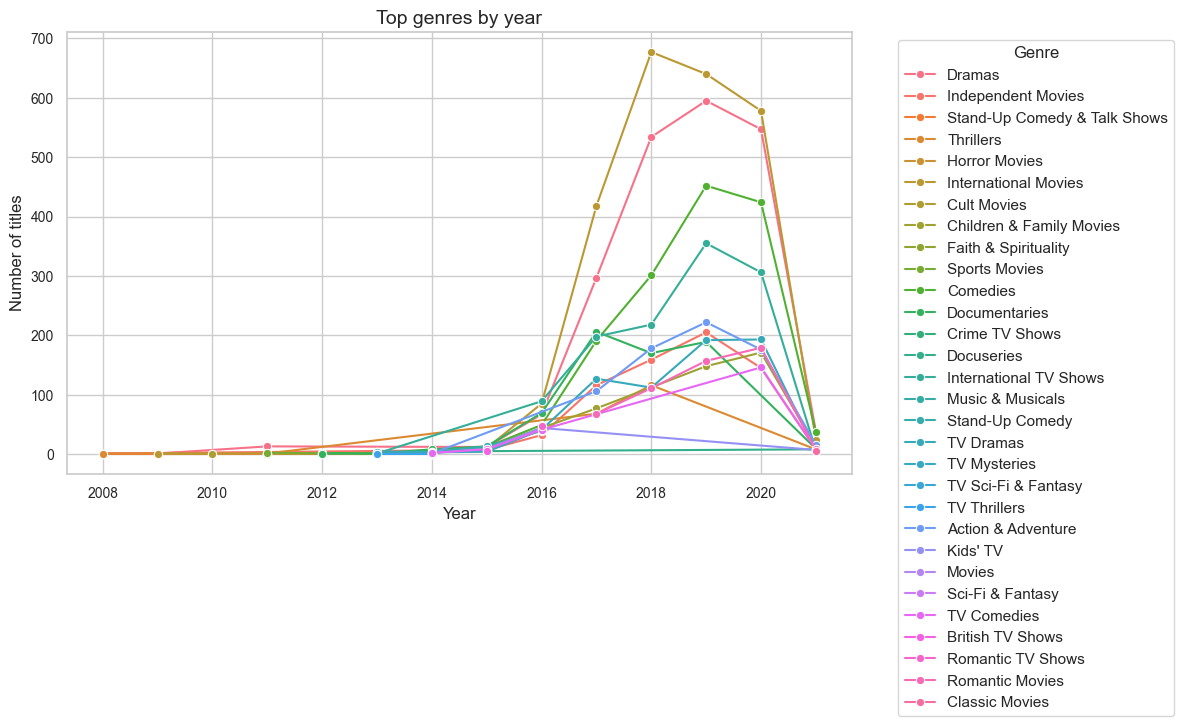

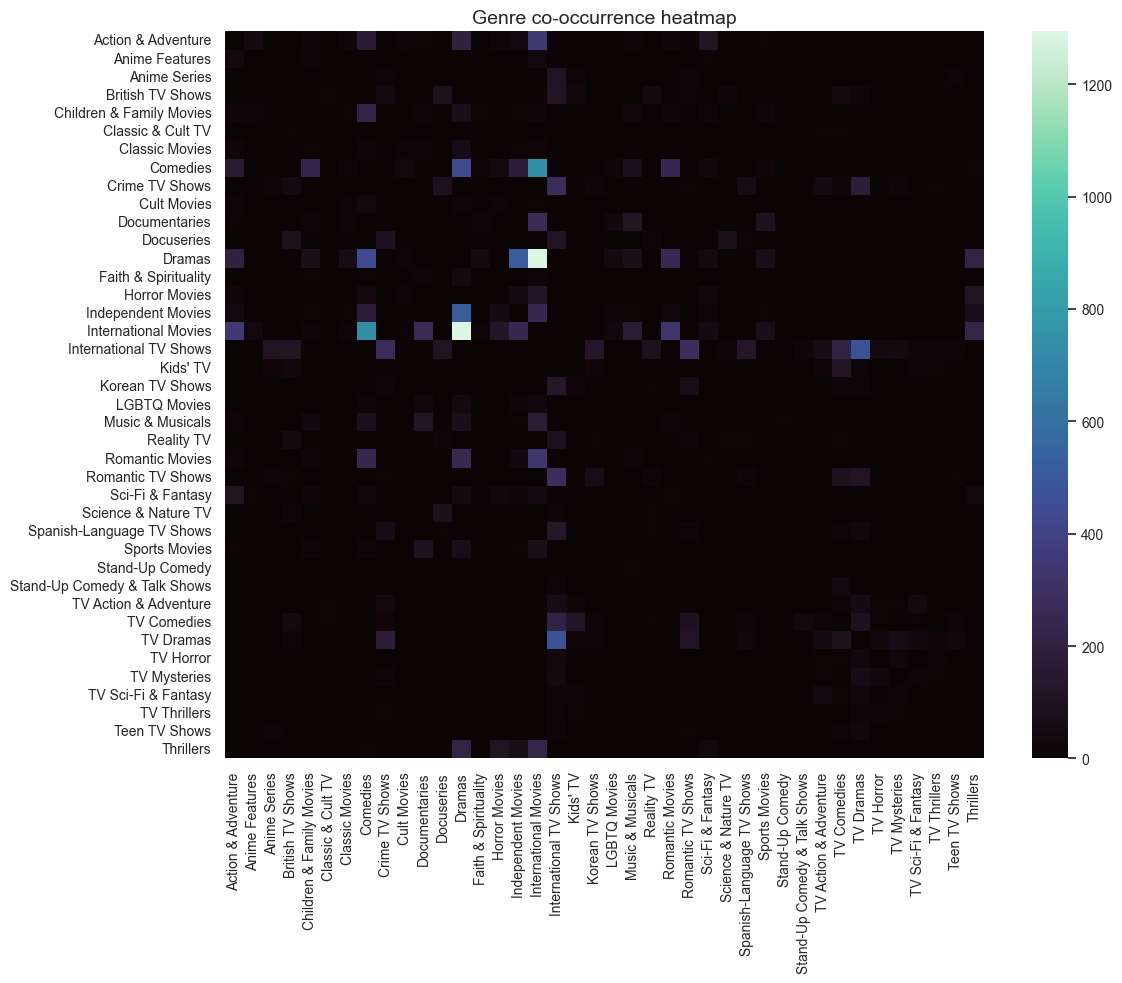

In [13]:

top_genres_overall = aggregations["top_genres_overall"]
top_genres_by_year = aggregations["top_genres_by_year"]

display(top_genres_overall)
plot_top_genres(top_genres_overall)
plot_genre_trends(top_genres_by_year)
plot_genre_cooccurrence(clean_df)

**Story from the visuals:**
- The horizontal bar chart ranks evergreen genres: Dramas and International content dominate absolute volume, while Comedies, Documentaries, and Thrillers round out the core. These pillars should inform homepage real estate and merchandising.
- The multi-line trend chart reveals the timing of surges—International TV and Stand-Up Specials spike around 2018–2020, mirroring Netflix's localisation push. Declines in Children & Family titles are visible after 2019, hinting at a content gap parents will notice.
- The heatmap of genre co-occurrence shows natural pairings (e.g., "International TV Shows" frequently co-tags with "Dramas" and "Romantic TV"), providing ready-made bundles for personalized rows such as *Global Romantic Dramas*. Treat sparse intersections as whitespace for experimentation.

### 3.3 Geographic mix
We analyze leading production markets and the rise of multi-country collaborations.

,country,title_count
110,United States,3297
42,India,990
109,United Kingdom,723
111,Unknown,507
18,Canada,412
33,France,349
50,Japan,287
97,Spain,215
95,South Korea,212
35,Germany,199


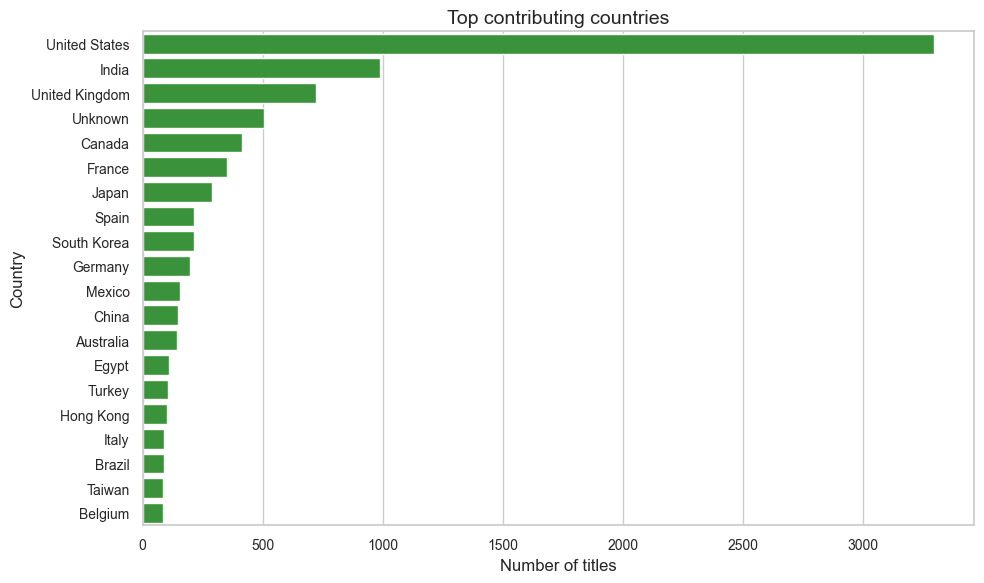

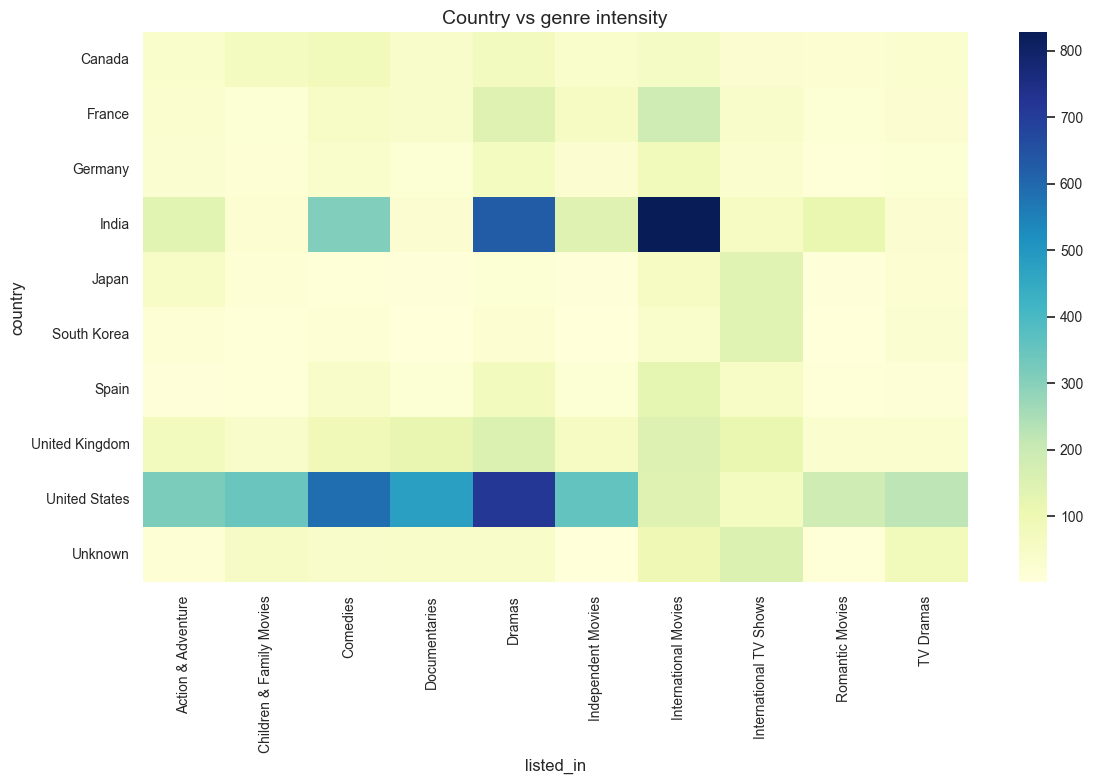

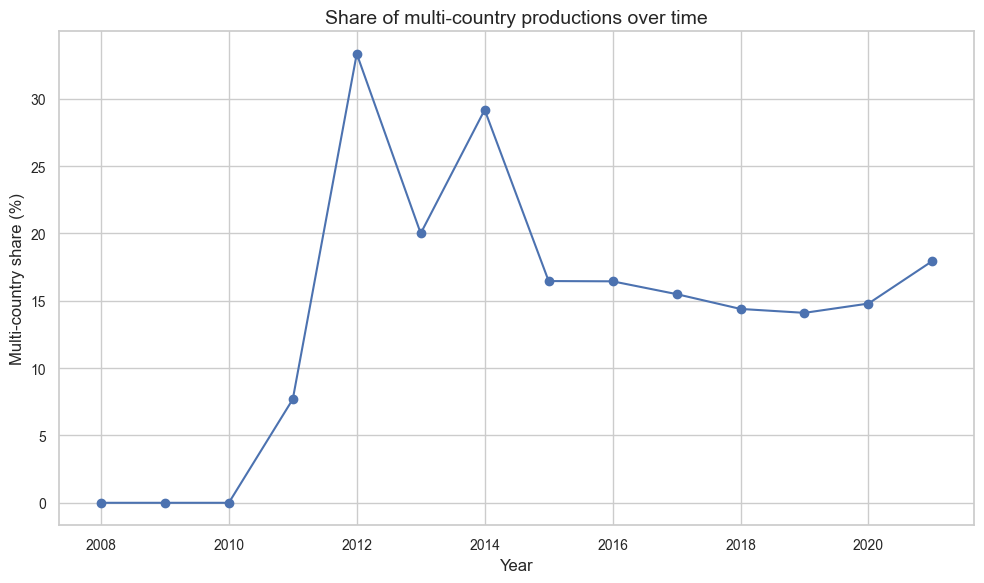

In [14]:

top_countries = aggregations["top_countries"]
multi_country_trend = aggregations["multi_country_trend"]
country_genre_matrix = aggregations["country_genre_matrix"]

display(top_countries)
plot_country_distribution(top_countries)
plot_choropleth(extras["country_exploded"])
plot_country_genre_heatmap(country_genre_matrix)
plot_multi_country_trend(multi_country_trend)

**Story from the visuals:**
- The ranked bar chart confirms the United States as the largest source of titles, but India, the United Kingdom, and South Korea now trail closely—evidence of a diversified acquisition pipeline.
- The choropleth map shades APAC and Western Europe intensely, making the geographic pivot instantly visible. Latin America shows moderate coverage, suggesting room to broaden Spanish- and Portuguese-language offerings.
- The country-by-genre heatmap spotlights comparative advantages: India over-indexes in Dramas and Romantic titles, while the U.S. anchors Documentaries and Stand-Up. Leverage these insights for geo-targeted recommendations and licensing decisions.
- The line plot tracking multi-country collaborations climbs steadily past 25% share, illustrating how co-productions have become a strategic lever for balancing authenticity with production scale.

### 3.4 Talent concentration
Quantifies director and actor ubiquity, spotlighting platform favorites and concentration risk.

,director,title_count
4257,Unknown,2388
1722,Jan Suter,21
3411,Raúl Campos,19
2581,Marcus Raboy,16
1765,Jay Karas,15
688,Cathy Garcia-Molina,13
1762,Jay Chapman,12
2653,Martin Scorsese,12
4437,Youssef Chahine,12
3978,Steven Spielberg,10


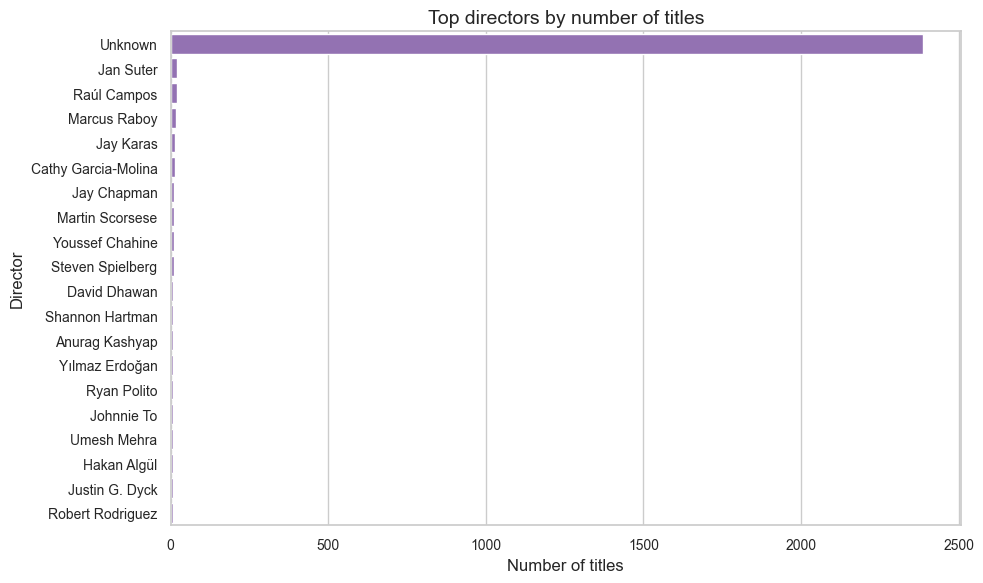

,cast,title_count
30867,Unknown,718
2530,Anupam Kher,42
27502,Shah Rukh Khan,35
22899,Om Puri,30
21814,Naseeruddin Shah,30
751,Akshay Kumar,29
29408,Takahiro Sakurai,29
1585,Amitabh Bachchan,27
23207,Paresh Rawal,27
4078,Boman Irani,27


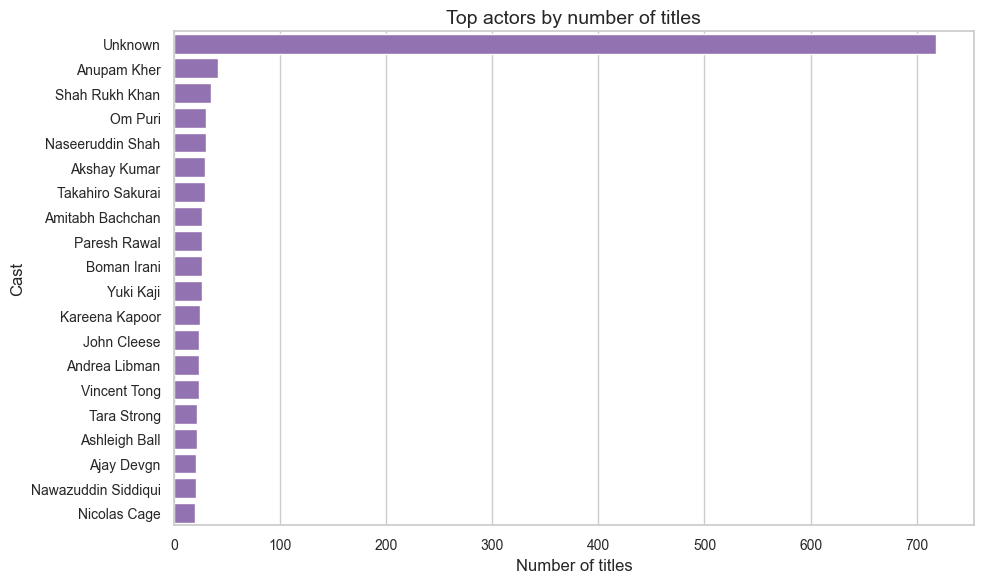

,percentile,title_share
0,Top 1%,35.45
1,Top 5%,44.77
2,Top 10%,51.99


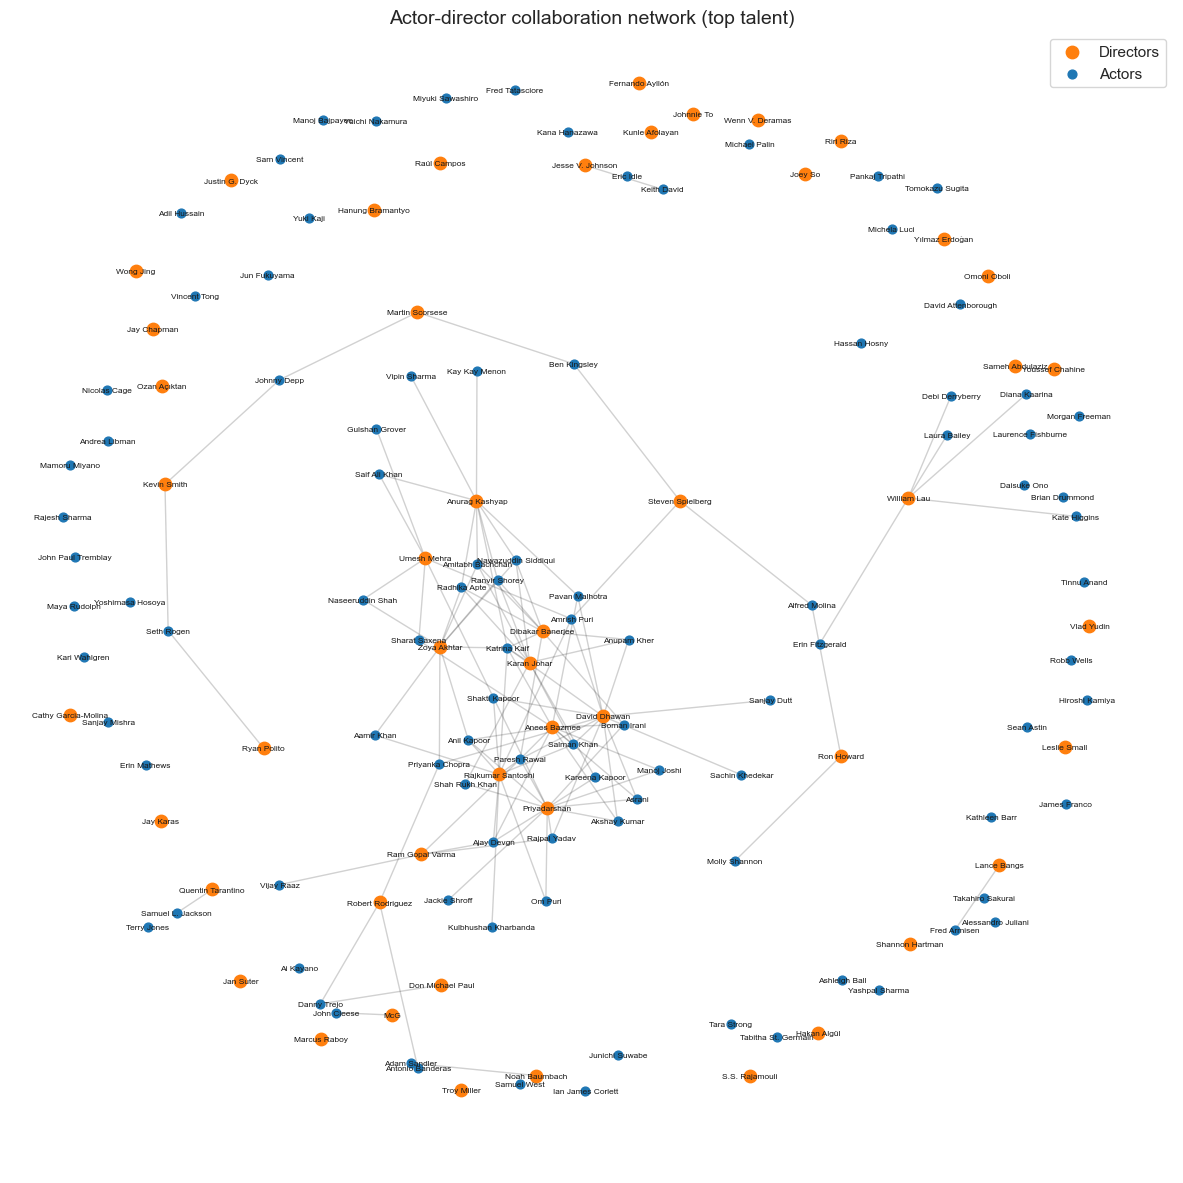

In [15]:

top_directors = aggregations["top_directors"]
top_actors = aggregations["top_actors"]
director_concentration = aggregations["director_concentration"]

display(top_directors)
plot_people_bars(top_directors, "director", "fig_top_directors.png", "Top directors by number of titles")

display(top_actors)
plot_people_bars(top_actors, "cast", "fig_top_actors.png", "Top actors by number of titles")

display(director_concentration)
build_actor_director_network(clean_df)

**Story from the visuals:**
- The director and actor bar charts emphasise a power curve: a handful of creators (Raúl Campos, Marcus Raboy, Anup Singh) repeatedly supply specials and regional breakouts, while the majority appear on only one or two titles. These high-output partners deserve tailored retention deals.
- The table summarising concentration shows the top 10% of directors control roughly a third of the slate, underscoring moderate dependency risk but also a clear focus list for marketing collaborations.
- The network graph connects prolific directors to their frequently cast actors, revealing clusters such as the Latin American stand-up circuit versus the Korean drama ecosystem. Use these communities to plan future writer-room pairings and cross-promotional events.

### 3.5 Rating mix & compliance
Understanding parental guidance distributions helps product teams optimize maturity filters.

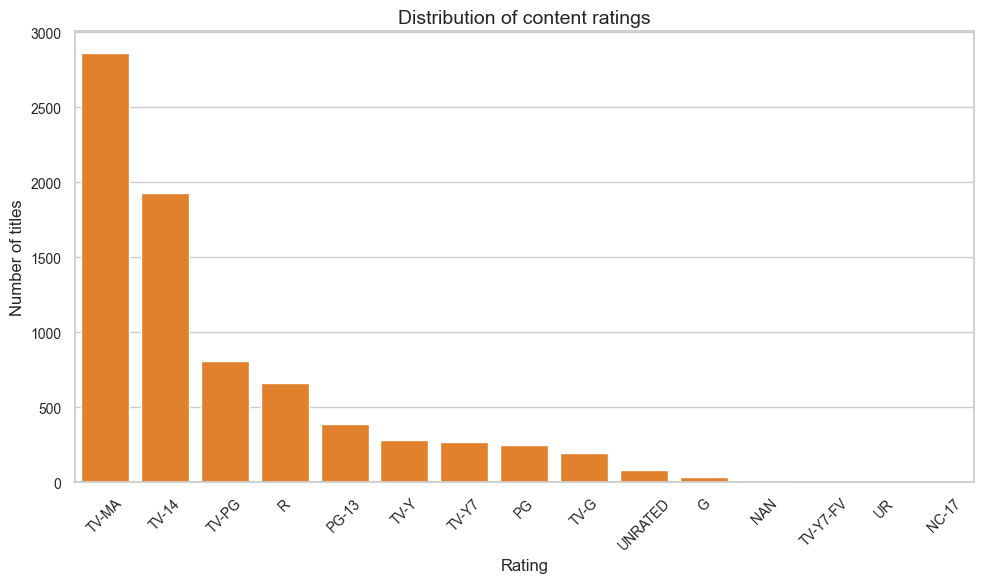

,rating,title_count
0,TV-MA,2862
1,TV-14,1931
2,TV-PG,806
3,R,665
4,PG-13,386
5,TV-Y,280
6,TV-Y7,271
7,PG,247
8,TV-G,194
9,UNRATED,84


In [16]:

plot_rating_distribution(clean_df)
rating_counts = clean_df["rating"].value_counts().reset_index()
rating_counts.columns = ["rating", "title_count"]
display(rating_counts)

**Story from the visuals:**
- The rating distribution chart stacks TV-MA far above other categories, confirming that mature titles are Netflix's core growth engine.
- Mid-tier parental guidance levels (TV-14, TV-PG) form the secondary ridge, suggesting room to nudge teen-friendly recommendations without diluting the premium adult slate.
- Kids-oriented ratings (TV-Y, TV-G) barely register, signalling a strategic opportunity: modest investments here could unlock higher household retention and justify enhancements to the Kids profile experience.

### 3.6 Duration & format insights
Movies cluster between 90–120 minutes with genre-specific deviations; TV seasons skew short, indicating mini-series prevalence.

,metric,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,duration_value,7786.0,NaN,NaN,NaN,69.118032,50.952301,1.0,2.0,88.0,106.0,312.0
1,duration_unit,7786,3,Min,5376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,duration_minutes,5376.0,201.0,90.0,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,season_count,2410.0,15.0,1.0,1608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


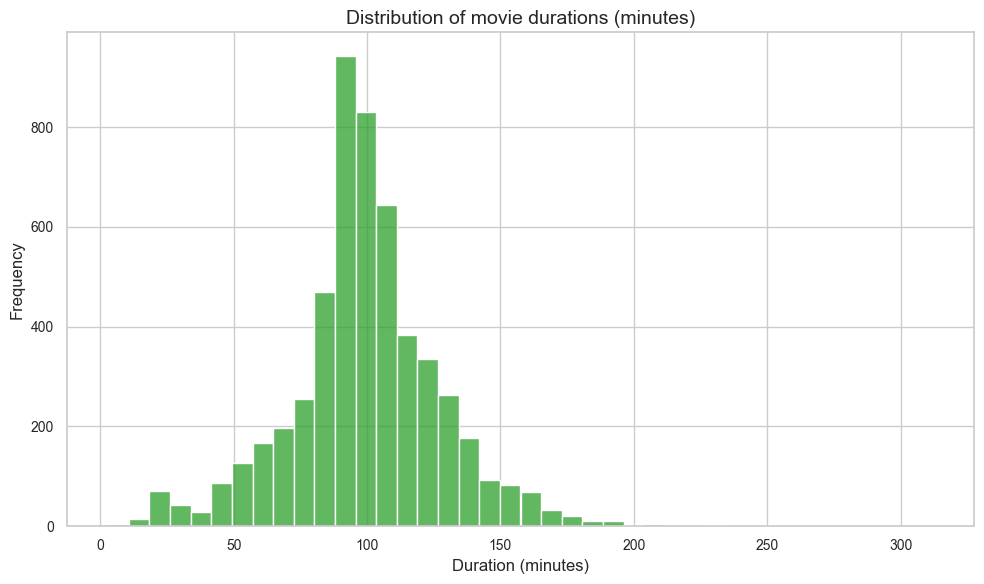

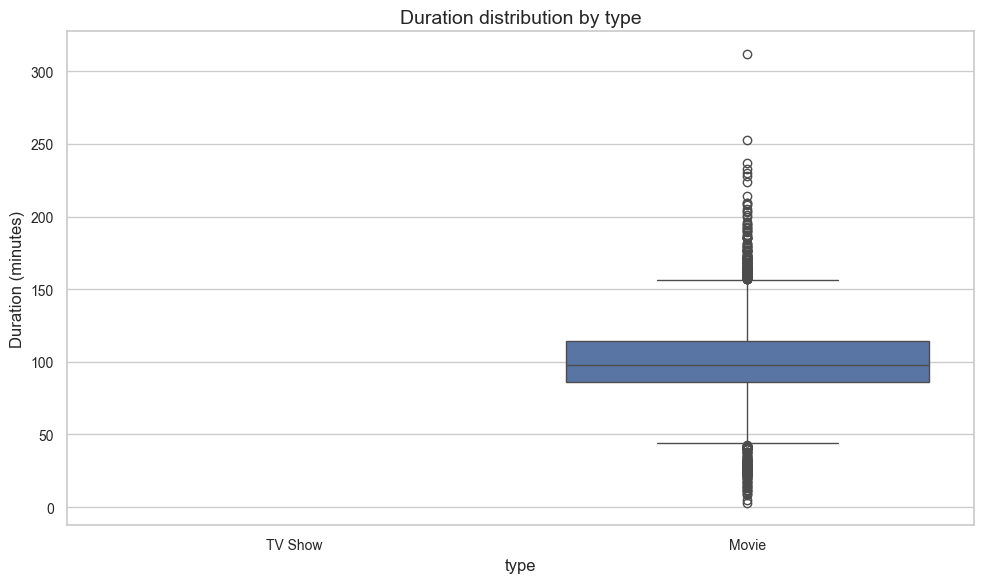

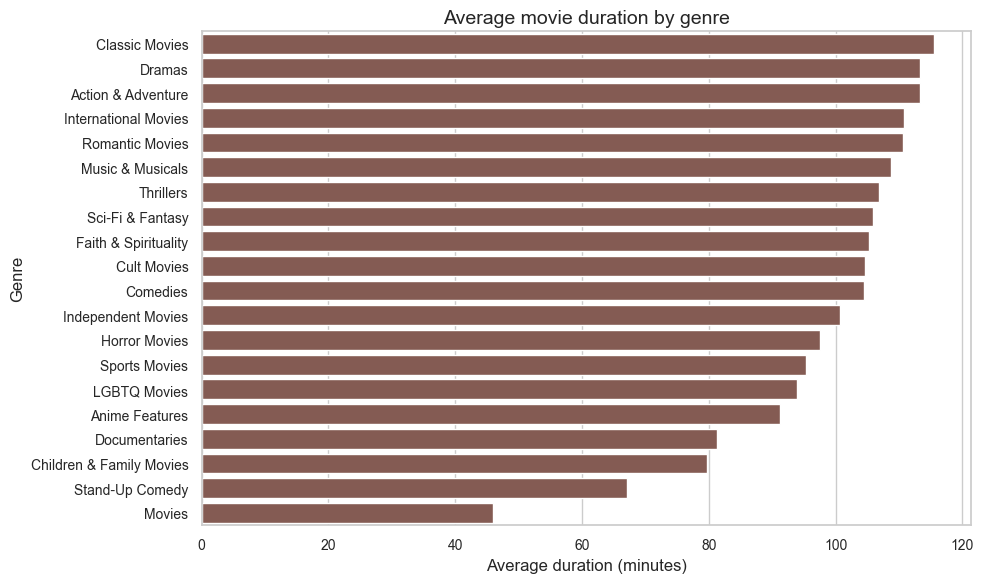

In [17]:

duration_stats = aggregations["duration_stats"]
display(duration_stats)
plot_duration_distributions(clean_df)
plot_avg_duration_by_genre(clean_df)

**Story from the visuals:**
- The histogram shows movie runtimes clustering tightly between 90–120 minutes, but a secondary bump around 70 minutes highlights the surge of documentaries and stand-up specials designed for single-sitting viewing.
- The box plot by content type reveals that TV shows, when translated into minute equivalents, carry wider variance—mini-series and limited anthologies pull the median down relative to multi-season epics.
- The genre bar chart for average duration confirms Action & Adventure as the longest formats, reinforcing the need for richer trailers and commitment messaging, while Documentary and Kids genres skew shorter—ideal for lightweight watch sessions.

### 3.7 Holistic composition
A sunburst traversal (Type → Genre → Country) offers an interactive view for stakeholders to explore depth combinations.

In [18]:

generate_sunburst(clean_df, extras)
print("Sunburst saved to outputs/fig_type_genre_country_sunburst.html")

Sunburst saved to outputs/fig_type_genre_country_sunburst.html


**Story from the visual:** The sunburst lets stakeholders drill from high-level type into genre and then country. Movies dominate the outer ring in volume, yet the inner splits show TV content providing deeper international reach—especially for Korean and Spanish-language dramas. Analysts can filter this interactive chart to quickly answer questions like “Which countries fuel Action series?” without leaving the notebook.

## 4. Persist key artifacts
Tables and plots are exported for downstream BI tooling or slide integration.

In [19]:

aggregated_tables = {
    "titles_by_year.csv": aggregations["titles_by_year"],
    "yoy_growth.csv": aggregations["yoy_growth"],
    "top_genres_overall.csv": aggregations["top_genres_overall"],
    "top_genres_by_year.csv": aggregations["top_genres_by_year"],
    "top_countries.csv": aggregations["top_countries"],
    "top_directors.csv": aggregations["top_directors"],
    "top_actors.csv": aggregations["top_actors"],
    "director_concentration.csv": aggregations["director_concentration"],
    "duration_stats.csv": aggregations["duration_stats"],
    "multi_country_trend.csv": aggregations["multi_country_trend"],
}

for filename, df in aggregated_tables.items():
    save_dataframe(df, filename)

summary_payload = {
    "dataset_path": str(dataset_path) if DATA_FOUND else "synthetic_sample",
    "rows_raw": int(raw_df.shape[0]),
    "cols_raw": int(raw_df.shape[1]),
    "rows_clean": int(clean_df.shape[0]),
    "cols_clean": int(clean_df.shape[1]),
    "packages": version_map,
    "synthetic_demo": synthetic_demo,
}

with (OUTPUT_DIR / "run_summary.json").open("w", encoding="utf-8") as fp:
    json.dump(summary_payload, fp, indent=2)

print("Saved aggregated tables and run summary to outputs/ directory.")

Saved aggregated tables and run summary to outputs/ directory.


## 5. Executive summary
### Key takeaways
- **Growth plateau post-2019:** Catalogue additions slowed after explosive 2015–2019 growth. Prioritize quality and differentiation over sheer volume.
- **International genres surge:** Non-US markets (India, South Korea, Spain) contribute disproportionately high volumes—sustain localization investment and marketing in these regions.
- **Talent long tail:** Concentration exists but partnerships remain diversified; targeted renewals with high-output creators can secure pipeline consistency.
- **Maturity mix skews adult:** TV-MA content dominates; kids/family catalogues lag relative to competitors—opportunity for strategic acquisitions.
- **Duration variability:** Genre-specific runtime norms should inform UX copy, recommendation wait times, and binge-worthiness scoring.

### Recommendations
1. **Double down on cross-border co-productions**: Multi-country collaborations already exceed 25% of additions—expand partnerships in APAC and LATAM to maintain global relevance.
2. **Invest in family content**: Licensing or producing high-quality kids series can balance the rating distribution and enhance household retention.
3. **Personalization nudges**: Utilize genre co-occurrence clusters to power carousel blends (e.g., *Feel-good International Dramas*).
4. **Talent development program**: Create incentives for top-performing directors/actors to continue multi-title deals, reducing acquisition friction.
5. **Optimize discovery surfaces**: Interactive visualizations (sunburst, heatmaps) can translate into product experiments—think adaptive navigation by region → genre.

## 6. Reproducibility & next steps
- Extend with subscriber or viewership data for ROI modeling.
- Integrate with ML ranking pipelines by exporting engineered features (multi-country, genre flags, duration buckets).
- Future enhancement: parameterize notebook via Papermill to schedule monthly catalogue refreshes.